# SEGMENTATION DES CLIENTS

## Introduction
<br>Pour le business mieux connaitre ses clients est primordial pour avoir une relation personnalisée avec eux, leur proposer des produits pertients pour eux. Par exemple, Différentes publicités peuvent être élaborées et envoyées à différents segments d'audience en fonction de leur profil démographique, de leurs intérêts et de leur niveau de richesse.</br>

<br>Il exite plusieurs algorithmes non supervisés qui vous aideront à effectuer cette tâche. Durant ce cours nous allons nous focaliser sur l'un des plus célèbre d'entre eux: <b>K-means Clustering</b>. Cet algorithme prend en entrée des données non labellisées et assigner chaque donnée à un cluster. Le but des K-means est de grouper les données en des clusters qui ne se chevauchent pas et qui sont différents les uns des autres. Cela signifie que chaque sous-groupe/cluster sera composé de caractéristiques qui le distinguent des autres clusters.
</br>

<br>Cette technique est fréquemment utilisée par les data scientistes, pour aider les compagnies dans la tâche de segmentation. Durant ce cours nous allons explorer les points suivants:
<ul>
<li>Pré-processing des données;</li>
<li>Construction des segments;</li>
<li>Evaluation de l'algortihme;</li>
<li>Visualisation des segments;</li>
<li>Interpretation des segments.</li>
</ul>
 </br>

## Importation des librairies utiles

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lecture du jeu de données

In [7]:
df = pd.read_csv('Mall_Customers.csv', index_col=0)
print(f"le nombre de valeurs manquantes est: {df.isna().sum().sum()}")
print(df.shape)
df.head()

le nombre de valeurs manquantes est: 0
(200, 4)


Gender  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

Le jeu de données n'a pas de valeurs manquantes, 200 clients et 4 variables qui caractérisent chacun des clients. la variable Gender est catégorielle, donc doit être encodée en variable numérique. Les autres variables sont numériques mais doivent être standardisées pour s'assurer que les segments que nous auront à la fin ne sont pas influencés par les valeurs des variables.

In [74]:
df.dtypes

Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
cluster                    int32
dtype: object

In [15]:
df.describe()

Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000

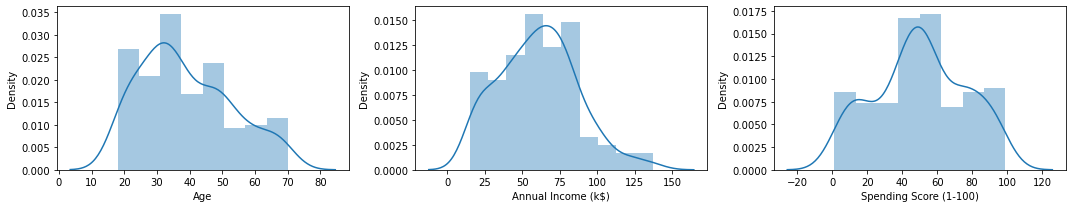

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(df['Age'], ax=ax[0])
sns.distplot(df['Annual Income (k$)'], ax=ax[1])
sns.distplot(df['Spending Score (1-100)'], ax=ax[2])
plt.tight_layout()
plt.show()

## Standardisation et encodage des variables
<br>En statistique, les variables standardisées sont des variables qui ont été normalisées pour avoir une moyenne de 0 et un écart-type de 1. Cette méthode assure que vous assure que l'algorithme n'est pas influencé par des valeurs singulières au sein de votre jeu de données. Considérons une variable aléatoire $X$, de moyenne $\mu$ et de variance $\sigma$, sa version standardisée est
$$Z = \frac{(X - \mu)}{\sigma}$$
 </br>

In [31]:
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[col_names]

In [17]:
## méthode 1
def standardscaler(X):
    return (X-X.mean())/X.std()

In [18]:
scaled_features1 = features.apply(standardscaler)
scaled_features1.head()

Annual Income (k$)       Age  Spending Score (1-100)
CustomerID                                                      
1                    -1.734646 -1.421003               -0.433713
2                    -1.734646 -1.277829                1.192711
3                    -1.696572 -1.349416               -1.711618
4                    -1.696572 -1.134655                1.037814
5                    -1.658498 -0.561958               -0.394989

In [32]:
# méthode 2
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

Annual Income (k$)       Age  Spending Score (1-100)
0           -1.738999 -1.424569               -0.434801
1           -1.738999 -1.281035                1.195704
2           -1.700830 -1.352802               -1.715913
3           -1.700830 -1.137502                1.040418
4           -1.662660 -0.563369               -0.395980

Toutes les variables numériques sont maintenant centrées autour de 0. La variable "Gender" est catégorique, et nous devons la transformer en une variable numérique. Cela signifie que nous devons substituer des nombres pour chaque catégorie. 

In [34]:
## Méthode 1
gender_dict = {'Male':0,
'Female':1}
scaled_features1['Gender'] = df['Gender'].map(gender_dict)
scaled_features1.head()

Annual Income (k$)       Age  Spending Score (1-100)  Gender
CustomerID                                                              
1                    -1.734646 -1.421003               -0.433713       0
2                    -1.734646 -1.277829                1.192711       0
3                    -1.696572 -1.349416               -1.711618       1
4                    -1.696572 -1.134655                1.037814       1
5                    -1.658498 -0.561958               -0.394989       1

In [39]:
scaled_features.index = df.index

In [40]:
scaled_features['Gender'] = df['Gender']
newdf = pd.get_dummies(scaled_features, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

newdf = newdf.drop(['Gender_Male'],axis=1)

newdf.head()

Annual Income (k$)       Age  Spending Score (1-100)  \
CustomerID                                                         
1                    -1.738999 -1.424569               -0.434801   
2                    -1.738999 -1.281035                1.195704   
3                    -1.700830 -1.352802               -1.715913   
4                    -1.700830 -1.137502                1.040418   
5                    -1.662660 -0.563369               -0.395980   

            Gender_Female  
CustomerID                 
1                       0  
2                       0  
3                       1  
4                       1  
5                       1

Nous pouvons voir que la variable genre a été transformée. Vous avez peut-être remarqué que nous avons supprimé 'Gender_Male' du dataframe. Cela s'explique par le fait qu'il n'est plus nécessaire de conserver cette variable.
Les valeurs de "Gender_Male" peuvent être déduites de "Gender_Female" (c'est-à-dire que si "Gender_Female" vaut 0, alors "Gender_Male" vaudra 1 et vice versa).

## Clustering

In [41]:
from clustering import Kmeans

In [46]:
kmeans = Kmeans(newdf)

In [43]:
kmeans.elbow_inertia(100)

10
20
30
40
50
60
70
80
90


<b>L'indice de Silhouette</b>
<br> Un coefficient de silhouette, ou un score de silhouette, est une métrique utilisée pour évaluer la qualité des clusters créés par l'algorithme. Les scores de silhouette vont de -1 à +1. Plus le score de silhouette est élevé, meilleur est le modèle.
Le score de silhouette mesure la distance entre tous les points de données au sein d'un même cluster. Plus cette distance est faible, meilleur est le score de silhouette.Il mesure également la distance entre un objet et les points de données du cluster le plus proche. Plus cette distance est élevée, mieux c'est.

Un score de silhouette proche de +1 indique une bonne performance de clustering, et un score de silhouette proche de -1 indique un mauvais modèle de clustering.

</br>

<b>L'indice de Calinski-Harabasz </b>
<br> Il mesure la qualité de partition d'un ensemble de données. C'est le rapport entre la variance inter-groupes et la variance intra-groupe. Plus il est élévé, meilleure est la partition.

</br>

2
4
6
8
10


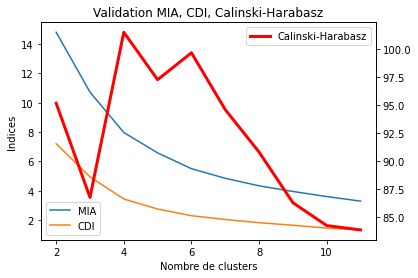

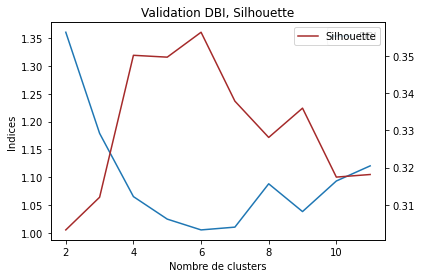

In [44]:
kmeans.cross_validation(12)

Les graphiques précédents nous indiquent de prendre 4 comme nombre de clusters. Le score silhouette ici vaut 0.35 qui n'est pas mauvais. Mais on peut faire mieux en terme de séparation.

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

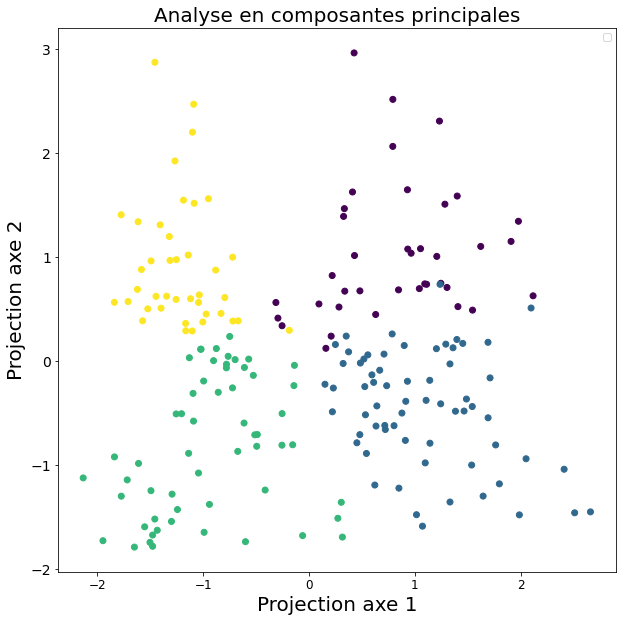

In [47]:
kmeans1, cluster,cluster_dict, pca = kmeans.fit(4)

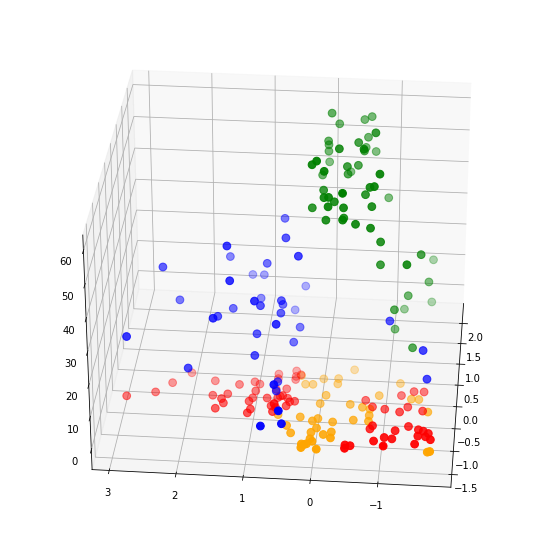

In [53]:
clusters = kmeans1.fit_predict(newdf.iloc[:,1:])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)

ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

La projection nous montre clairement que nos clusters ne sont pas bien séparés. Les points rouges sont mélangés avec les jaunes, et les bleus recouvrent les rouges.

Ceci, ainsi que le score de la silhouette, nous montre que le modèle n'est pas très performant.

Maintenant, créons un nouveau modèle qui a une meilleure séparabilité des clusters que celui-ci.

### Clustering modèle 2

Pour ce modèle, nous allons procéder à une sélection de features.

Nous allons utiliser une technique appelée Analyse en Composantes Principales (ACP).

L'ACP est une technique qui nous aide à réduire la dimension d'un ensemble de données. Lorsque nous exécutons l'ACP sur un cadre de données, de nouvelles composantes sont créées. Ces composantes expliquent le maximum de variance dans le modèle.

Nous pouvons sélectionner un sous-ensemble de ces variables et les inclure dans le modèle K-means.

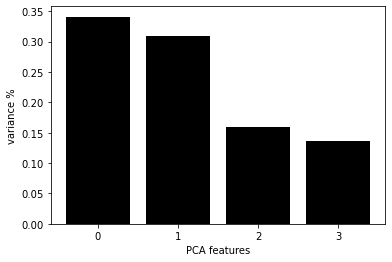

In [54]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

D'après cette visualisation, nous pouvons déduire que les deux premières composantes expliquent près de 70% de la variance du jeu de données. Nous allons utiliser ces deux composantes comme nouvelles variables et exécuter à nouveau l'algorithme des Kmeans.

In [55]:
kmeans = Kmeans(PCA_components.iloc[:,:2])

2
4
6
8
10


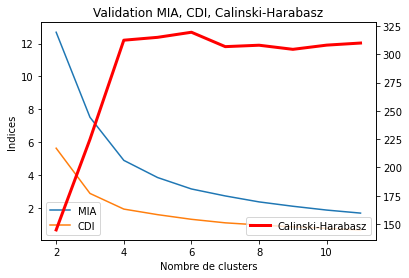

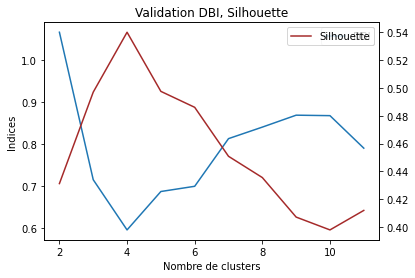

In [56]:
kmeans.cross_validation(12)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

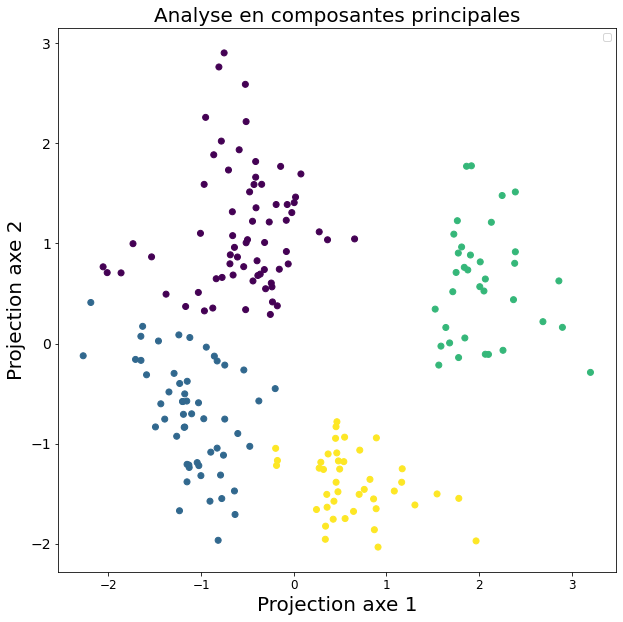

In [63]:
kmeans2, cluster,cluster_dict, pca = kmeans.fit(4)

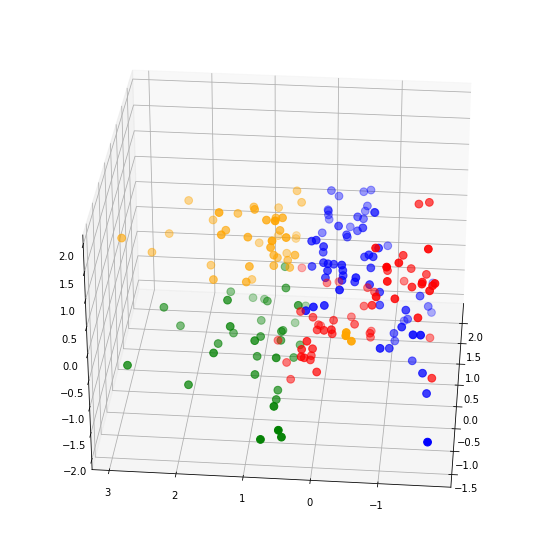

In [64]:
clusters = kmeans1.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)

ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

Notons que les Clusters sont mieux séparés dans le second modèle que dans le premier. De plus toutes les métriques se sont nettement améliorées. De ce fait nous allons utiliser ce second modèle pour analyser les segments.

## Analyse des clusters

In [65]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

# map back clusters to dataframe

pred = kmeans1.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)  cluster
0    Male   19                  15                      39        1
1    Male   21                  15                      81        1
2  Female   20                  16                       6        0
3  Female   23                  16                      77        1
4  Female   31                  17                      40        1

Un premiere analyse rapide serait de calculer la moyenne de toutes les variables numériques par cluster.

In [68]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
avg_df

cluster        Age  Annual Income (k$)  Spending Score (1-100)
0        0  52.352941           46.220588               39.852941
1        1  25.818182           42.981818               60.890909
2        2  41.685714           88.228571               17.285714
3        3  31.690476           83.738095               80.380952

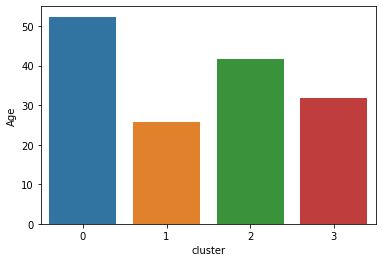

In [71]:
sns.barplot(x='cluster',y='Age',data=avg_df);

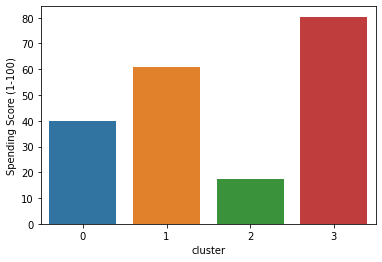

In [72]:
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df);

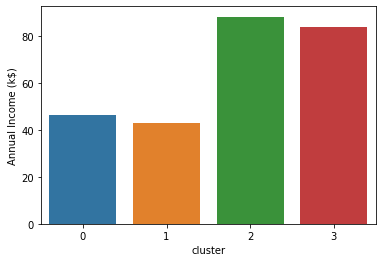

In [73]:
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df);

<b>Description de chaque segment</b>:
<ul>
<li>Segment 0: Segment des personnes agées, Revenu moyen faible , capacité de dépense moyenne;</li>
<li>Segment 1: Segment des personnes jeunes, revenu moyen faible, capacité de dépense élevée;</li>
<li>Segment 2: revenu moyen très élévé, capacité de dépenses faible.</li>
<li>Segment 3: revenu moyen très élévé, capacité de dépenses élevée.</li>


 </b>

Exercice: Caractérisez plus finement ces segments.